# Part 1: Exploratory Data Analysis #

In [75]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Create DataFrame from json file
df = pd.read_json('logins.json')
df.shape

(93142, 1)

In [54]:
# View the first few lines
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [55]:
# Check datatype
print(df['login_time'].dtypes)

datetime64[ns]


In [56]:
# Count logins per 15 minute interval
agg_15m = df.set_index('login_time').sort_index().resample('15T').size()
agg_15m.shape

(9788,)

In [57]:
# View the first few lines
agg_15m.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

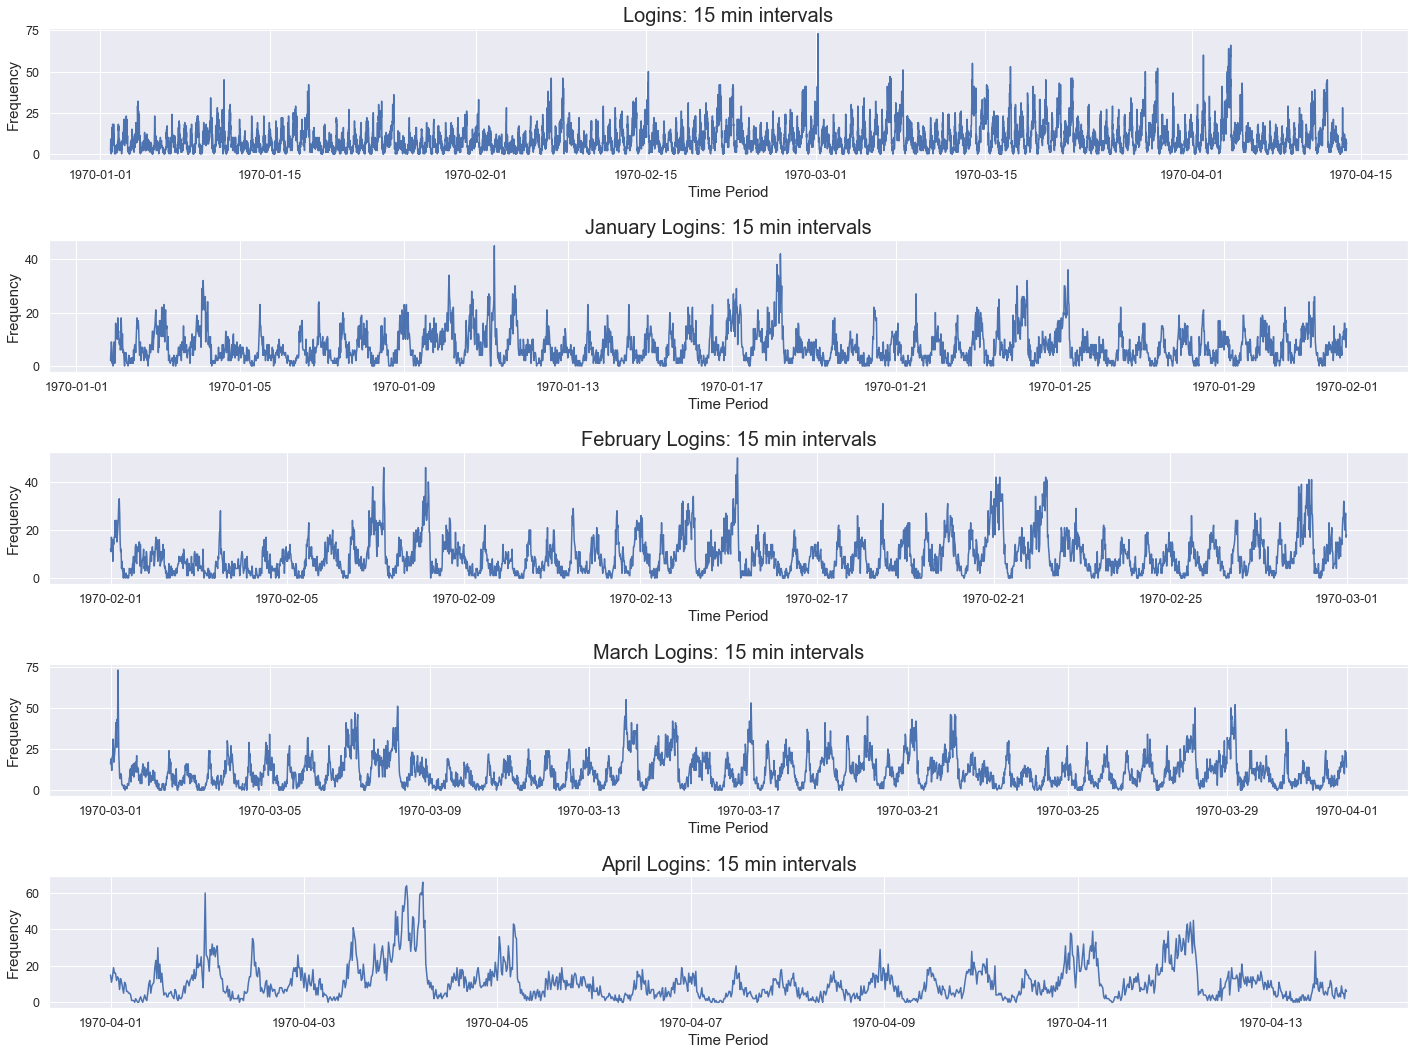

In [77]:
# Set style and size of plots
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 15))

# Plot count per 15 minute interval
plt.subplot(5, 1, 1)
plt.plot(agg_15m)
plt.title('Logins: 15 min intervals', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

# Plot count per 15 minute interval for each month individually
plt.subplot(5, 1, 2)
plt.plot(agg_15m.loc['1970-01-01':'1970-01-31'])
plt.title('January Logins: 15 min intervals', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 3)
plt.plot(agg_15m.loc['1970-02-01':'1970-02-28'])
plt.title('February Logins: 15 min intervals', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 4)
plt.plot(agg_15m.loc['1970-03-01':'1970-03-31'])
plt.title('March Logins: 15 min intervals', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.subplot(5, 1, 5)
plt.plot(agg_15m.loc['1970-04-01':'1970-04-30'])
plt.title('April Logins: 15 min intervals', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)

plt.tight_layout()
plt.show()

The spikes in the plots above correspond to the daily cycle indicating that there are certain times of day with many more logins, which we will see more about soon.  For the moment we will aggregate by day in order to see longer trends more easily.

In [72]:
# Resample to get daily totals
agg_day = agg_15m.resample('D').sum()
agg_day.shape

(103,)

In [73]:
# View the first few lines
agg_day.head()

login_time
1970-01-01    112
1970-01-02    681
1970-01-03    793
1970-01-04    788
1970-01-05    459
Freq: D, dtype: int64

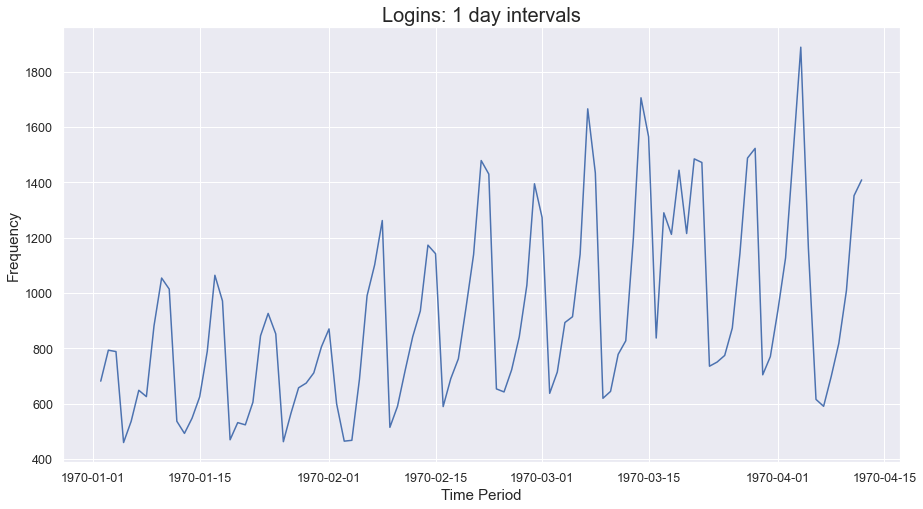

In [84]:
# Plot daily totals
agg_day = agg_day[1: -1]
plt.figure(figsize=(15, 8))
plt.plot(agg_day)
plt.title('Logins: 1 day intervals', size=20)
plt.xlabel('Time Period', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12.5)
plt.yticks(size=12.5)
plt.show()

The plot above shows the total number of logins each day, rather than every 15 minutes.  Now it is easier to see that there is a spike corresponding to each week, and that the total number of logins is trending up.  Next we can look at what particular days of the week have the most traffic.

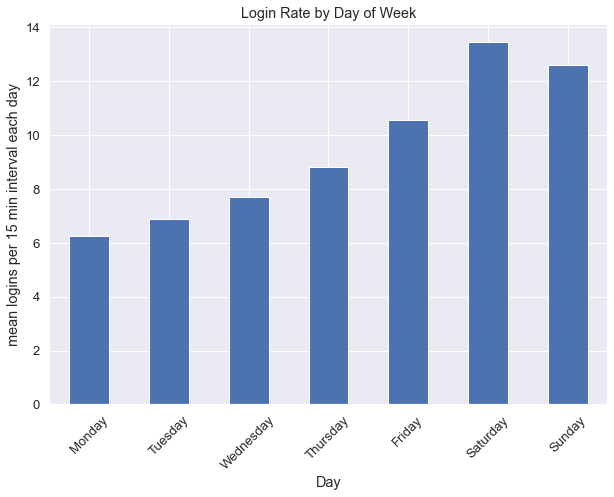

In [187]:
weekday_avg = agg_15m["1970-01-02": "1970-04-12"].groupby(agg_15m["1970-01-02": "1970-04-12"].index.weekday).mean()
weekday_avg.index.name = "Day"

weekday_avg.plot(kind='bar', y="count", rot=45, figsize=(10,7))
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel("mean logins per 15 min interval each day")
plt.title("Login Rate by Day of Week")
plt.show()

The bar chart above shows the mean number of logins during each 15 minute interval for each day of the week. The number of logins per day grows steadily from Monday to Saturday, and then drops slightly on Sunday.  We can also look at what times of day have the most most logins.

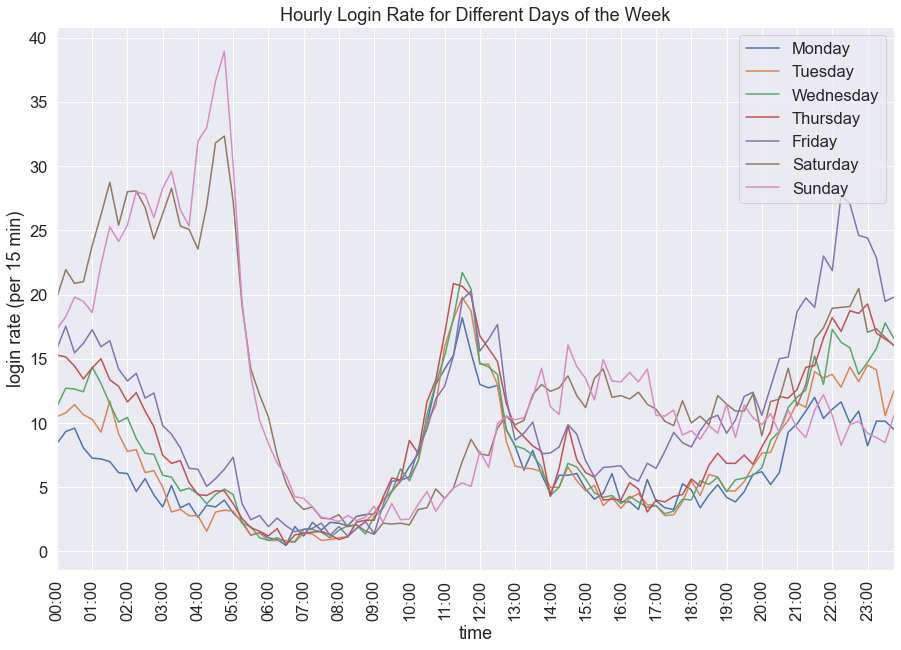

In [99]:
time_of_day = agg_15m.groupby([agg_15m.index.weekday, agg_15m.index.time]).mean()

day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(15, 10))
for i in range(7):
    time_of_day.loc[i].plot(label=day_of_week[i])
plt.ylabel("login rate (per 15 min)")
plt.xticks([3600 * h for h in range(24)], rotation='vertical')
plt.legend(loc="upper right")
plt.xlim([0, 3600 * 23.75])
plt.title("Hourly Login Rate for Different Days of the Week")
plt.show()

In the plot above, we see that there is a very different pattern for weekdays and weekends. Weekdays see a spike in the middle of the day, and a surge during the night, while weekends see a large surge in the early hours of the morning, and a small surge in the afternoon.

# Part 2: Experiment Metrics and Design #

1. The best measure of success for the initiative would be the reduction of average wait time in each city after implementing the policy to reimburse toll costs. It may also be useful to simply count the number of drivers who are active in both cities before and after the change. It is possible that this number could increase and average wait time stay the same, which would probably indicate that the intitiative has not been successful.


2. An experiment could be carried out by temporarily implementing the policy and comparing average wait time before and after the change. A paired t-test could then be used to test the significance of the results. This is useful for comparing the means of a continuous outcome variable of one group at two points in time. Average wait times for individual users before and after the change can be compared, preventing the results from being affected by the fact that different users might have different wait times due to their locations within the city or time of day/week they use the service. A difference score can be calculated for each user, and the average distance score can be divided by the standard error of the difference scores. The result is the t-statistic, which tells us how many standard errors from the mean the observed difference is. If the t-statistic is large enough to produce a p-value below a critical threshold (often 0.05) then the results are deemed to be significant.  This still does not necessarily mean that the change is a good idea from a business perspective. It may be that the added cost from reimbursing the tolls is greater than the increase in revenue from the policy change. And there might be time lag before the financial benefits of the change can be seen, as use of service might not increase immediately.

# Part 3: Predictive Modeling #

In [229]:
# Create a DataFrame from the CSV file
df = pd.read_json('ultimate_data_challenge.json')
df.shape

(50000, 12)

In [230]:
# View the first few rows
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [231]:
# General information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [232]:
# Change dates to datetime objects
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [233]:
# Statistical summary of numerical columns
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [234]:
# View distribution of cities
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [235]:
# View distribution of phones
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [236]:
# See how much missing data is there
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%', ascending=False)

,count,%
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000


In [237]:
# Find the most recent date
max_date = df['last_trip_date'].max()
print(max_date)

2014-07-01 00:00:00


We are going to calculate the difference between the `max_date` and the `last_trip_date` to give us the number of days since each user's last trip, which will be stored in the series `days_since_trip`.

In [238]:
timedelta_series = max_date - df.last_trip_date
days_since_trip = timedelta_series.dt.days
retained = days_since_trip <= 30
df['retained'] = retained.astype(int)
df.drop(columns='last_trip_date', inplace=True)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0


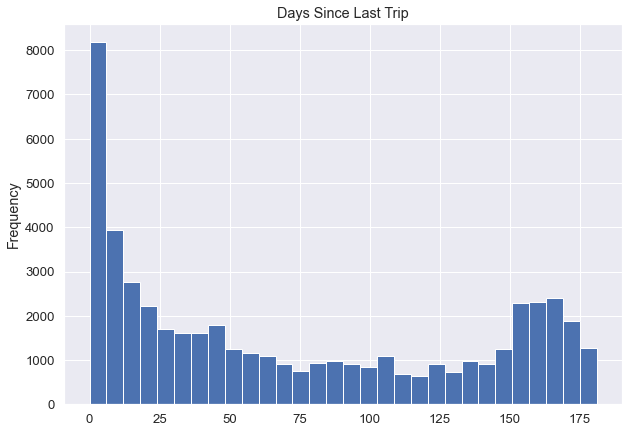

In [261]:
# Plot histogram of days since last trip
days_since_trip.plot(kind='hist', bins=30, figsize=(10, 7))
plt.title('Days Since Last Trip')
plt.show()

In [277]:
# See what portion of users are "retained"
retained_portion = pd.concat([df['retained'].value_counts(), 100 * df['retained'].value_counts() / len(df)], axis=1)
retained_portion.columns=['count', '%']
retained_portion

,count,%
0,31196,62.392
1,18804,37.608


In [240]:
# Change boolean column to 1s and 0s
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

Now we will see how much the different features are correlated with one another.  The bottom row is the most important, as it tells us how much different features correlate with the target feature.  Below that is a pairplot showing a scatterplot of each pair of features, as well as a histogram showing the distribution of each individual feature. Unfortunately, none of the features show a particularly strong relationship with the target variable.

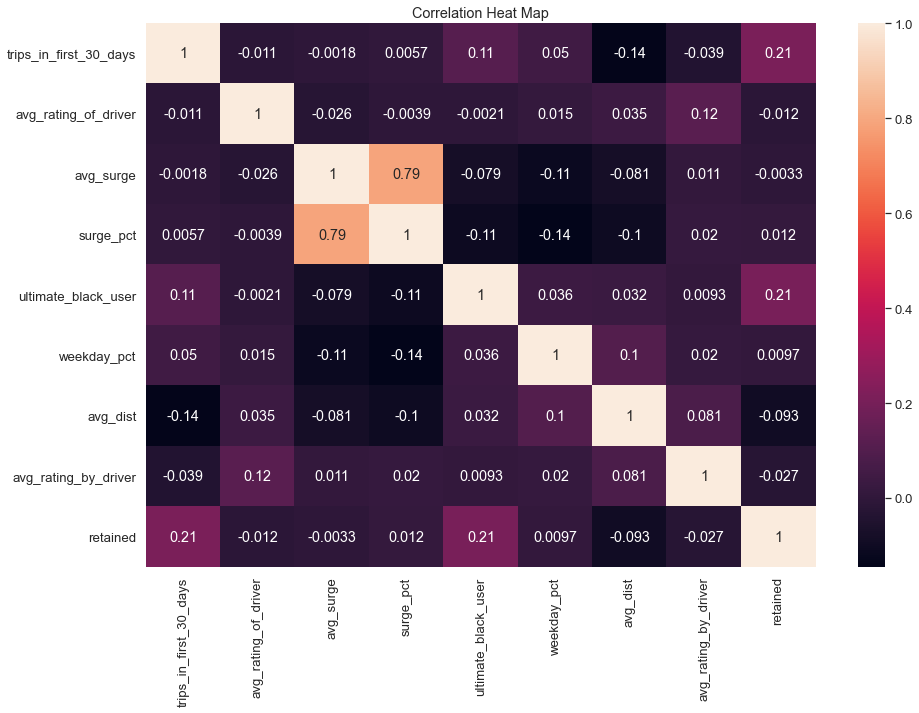

In [241]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Heat Map');

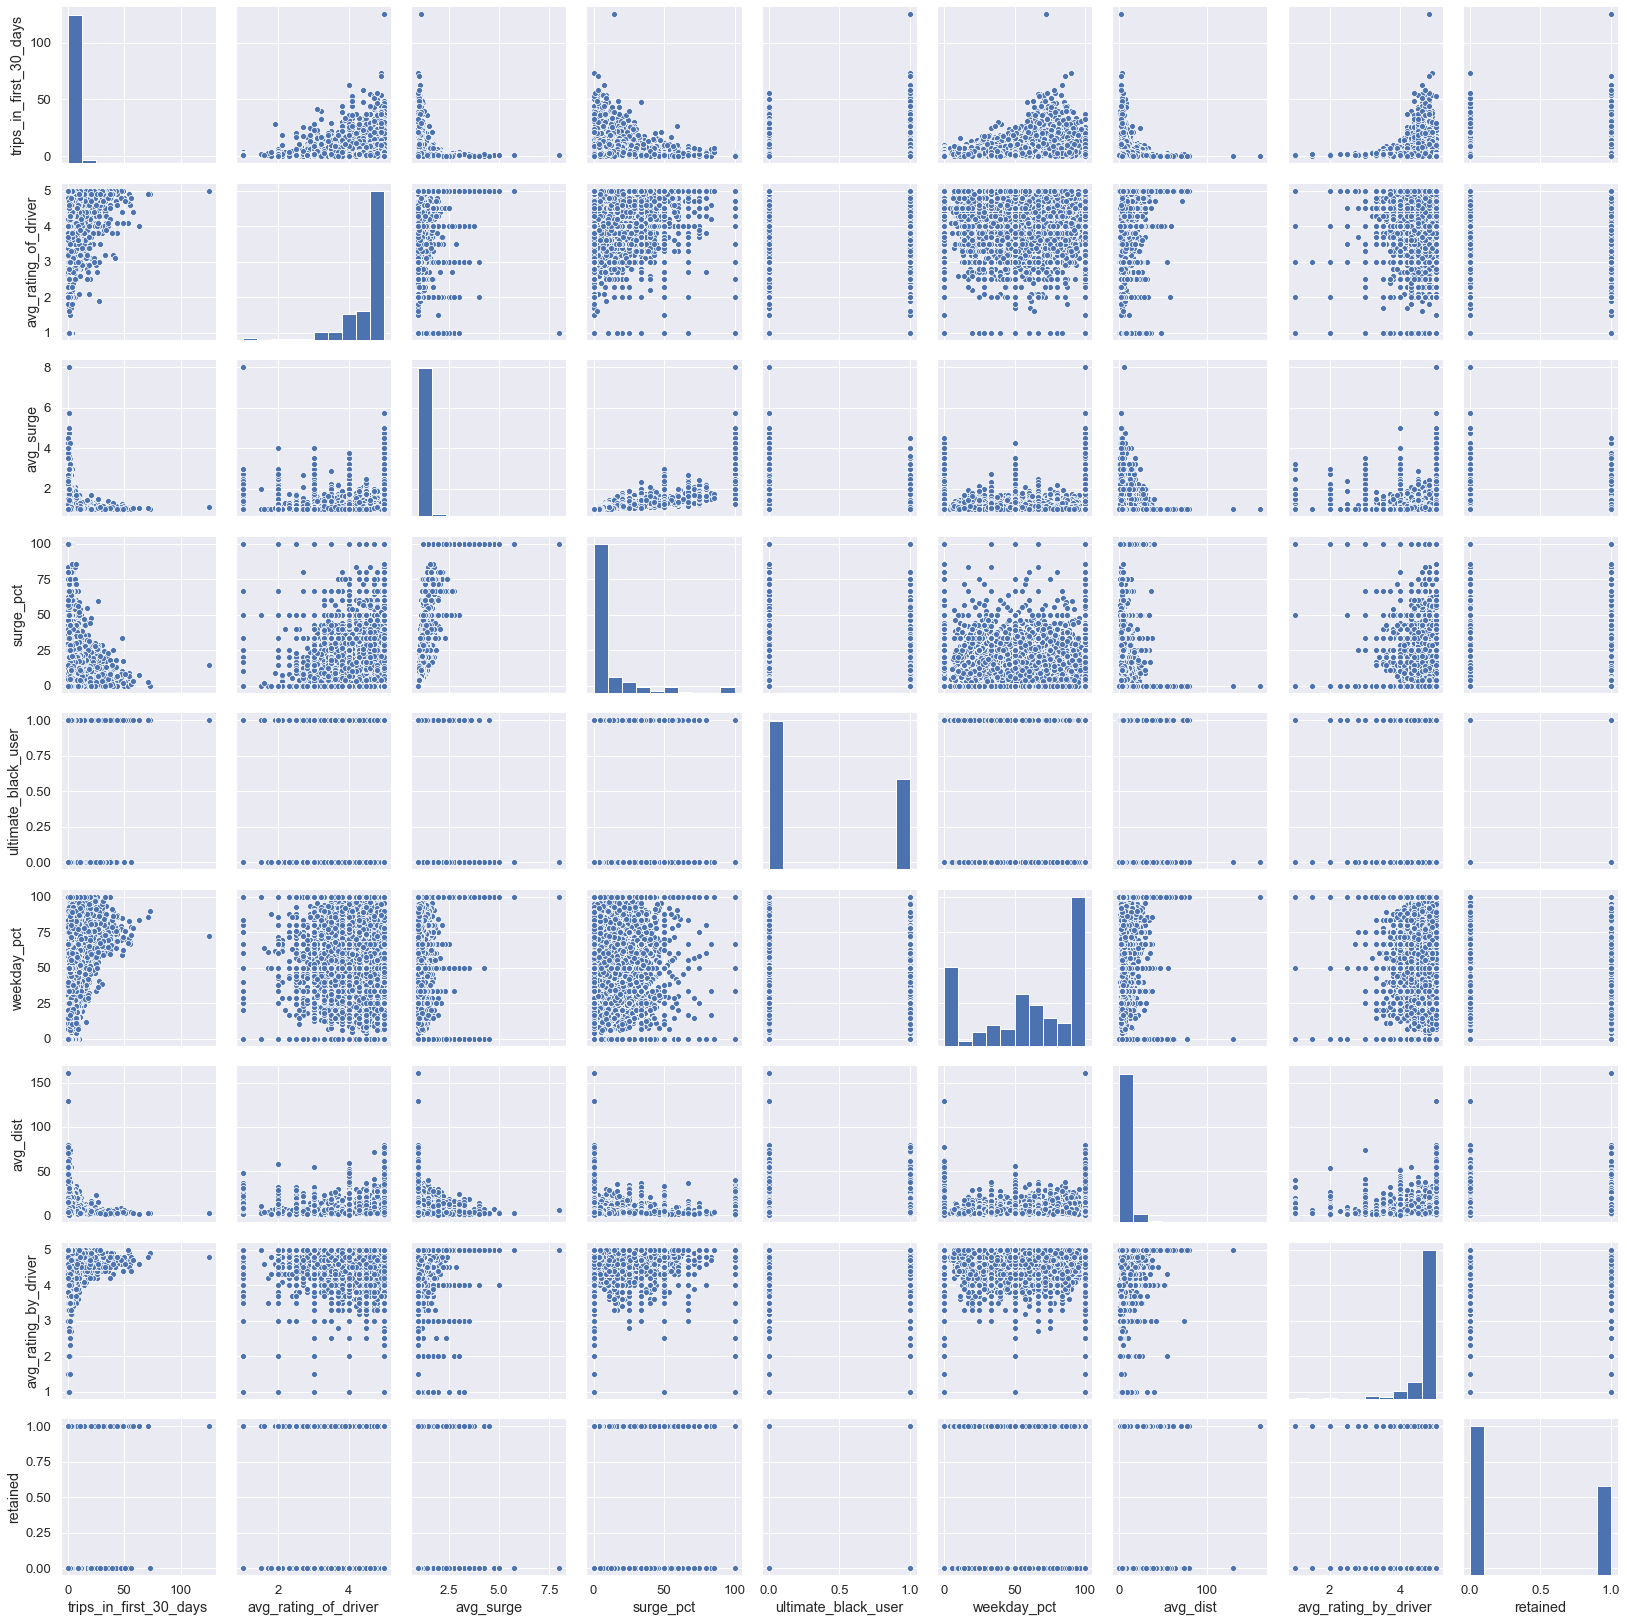

In [245]:
sns.set(font_scale=1.2)
sns.pairplot(df);

In [222]:
# Impute null values using mean or "unknown" for categorical variable
df.avg_rating_of_driver.loc[df.avg_rating_of_driver.isnull()] = df.avg_rating_of_driver.mean()
df.avg_rating_by_driver.loc[df.avg_rating_by_driver.isnull()] = df.avg_rating_by_driver.mean()
df.phone.loc[df.phone.isnull()] = 'unknown'

/Users/roberthollomanwalker/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [223]:
# See if there are any null values left
df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver      False
avg_surge                 False
phone                     False
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver      False
retained                  False
dtype: bool

In [224]:
# Use dummy variables to transform categorical features into binary
df = pd.get_dummies(df, columns=['city', 'phone'])
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unknown
0,4,2014-01-25,4.7,1.10,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1,0
4,14,2014-01-27,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [225]:
# Drop extra dummy vaiable
df.drop(columns='phone_unknown', inplace=True)
df.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'ultimate_black_user', 'weekday_pct',
       'avg_dist', 'avg_rating_by_driver', 'retained', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone'],
      dtype='object')

In [226]:
# Create DataFrame with independent features
X = df.drop(columns=['signup_date', 'retained'])
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,1,1,0


In [227]:
# Create Series with target feature
y = df.retained
y.head()

0    1
1    0
2    0
3    1
4    0
Name: retained, dtype: int64

In [250]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500, 13), (12500, 13), (37500,), (12500,))

In [253]:
# Import packages for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time

In [252]:
# Scaling the data can be helpful, particularly for k nearest neighbor
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-0.33934403, -1.42357489, -0.33362956, ...,  1.07191284,
        -0.65852156,  0.67099044],
       [-0.60598977,  0.3484985 , -0.33362956, ..., -0.93291167,
        -0.65852156,  0.67099044],
       [-0.60598977,  0.70291318, -0.33362956, ...,  1.07191284,
        -0.65852156,  0.67099044],
       ...,
       [ 2.06046762,  0.70291318, -0.33362956, ..., -0.93291167,
        -0.65852156,  0.67099044],
       [-0.60598977,  0.70291318,  0.78587261, ..., -0.93291167,
         1.51855316, -1.4903342 ],
       [ 2.86040484, -1.42357489,  0.06939122, ..., -0.93291167,
         1.51855316, -1.4903342 ]])

Now it is finally time to do some machine learning. The first model we use will be K Nearest Neighbor Classifier, using Grid Search with cross-validation to tune the hyperparameters. In the case the only hyperparameter is the value of "k". For this model and each subsequent model, we will record the training time, prediction time, accuracy, and ROC AUC.  At the end we can compare all of these metrics to select a model.

In [254]:
# Create instance of KNN Classifier
knn = KNeighborsClassifier()

# Define parameter grid and Grid Search model
grid_params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
knn_grid = GridSearchCV(knn, grid_params, cv = 5, verbose=1, n_jobs = -1)

# Fit model, recording time
start_time = time.time()
knn_grid.fit(X_train, y_train)
end_time = time.time()
knn_grid_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.8min finished


In [262]:
# View best parameters and runtime
print('best parameters: {}'.format(knn_grid.best_params_))
print('runtime: {} sec'.format(knn_grid_time))

best parameters: {'n_neighbors': 19}
runtime: 111.19 sec


In [263]:
# Get predictions and record prediction time
start_time = time.time()
y_pred = knn_grid.predict(X_test)
end_time = time.time()
knn_grid_pred_time = round((end_time - start_time) * 1000, 2)
print('prediction time: {} ms'.format(knn_grid_pred_time))

prediction time: 1859.21 ms


In [264]:
# View classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7800
           1       0.70      0.64      0.66      4700

    accuracy                           0.76     12500
   macro avg       0.74      0.73      0.74     12500
weighted avg       0.76      0.76      0.76     12500



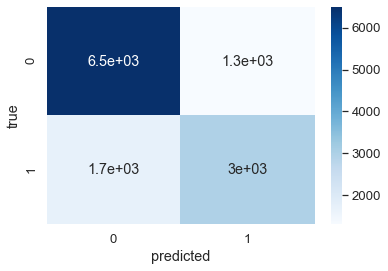

In [266]:
# View confusion matrix
sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

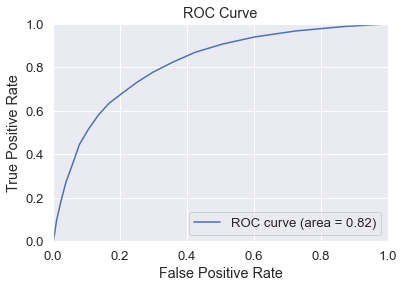

In [267]:
# Predict probabilities and plot the ROC curve
y_pred_prob = knn_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
knn_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % knn_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Using K Nearest Neighbor achieved an accuracy of 72% and an AUC of 0.82. Nearest Neighbor does not take too long to train, but the predictions take a long time because the model has to compare each point to all the training points. The next model to try will be logistic Regression.

In [270]:
# Create instance of Logistic Regression
logreg = LogisticRegression()

# Define parameter grid and Grid Search model
grid_params = {'C': np.logspace(-3, 4, 20), 'penalty': ['l1', 'l2']}
logreg_grid = GridSearchCV(logreg, grid_params, cv = 5, verbose=1, n_jobs = -1)

# Fit model, recording time
start_time = time.time()
logreg_grid.fit(X_train, y_train)
end_time = time.time()
logreg_grid_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


In [271]:
# View best parameters and runtime
print('best parameters: {}'.format(logreg_grid.best_params_))
print('runtime: {} sec'.format(logreg_grid_time))

best parameters: {'C': 0.00545559478116852, 'penalty': 'l2'}
runtime: 92.9 sec


In [272]:
# Get predictions and record prediction time
start_time = time.time()
y_pred = logreg_grid.predict(X_test)
end_time = time.time()
logreg_grid_pred_time = round((end_time - start_time) * 1000, 2)
print('prediction time: {} ms'.format(logreg_grid_pred_time))

prediction time: 7.0 ms


In [273]:
# View classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7800
           1       0.67      0.49      0.56      4700

    accuracy                           0.72     12500
   macro avg       0.70      0.67      0.68     12500
weighted avg       0.71      0.72      0.70     12500



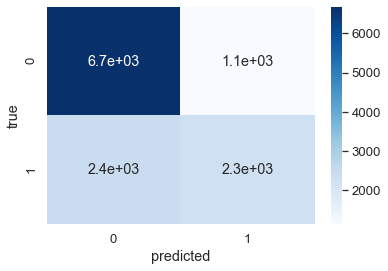

In [274]:
# View confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

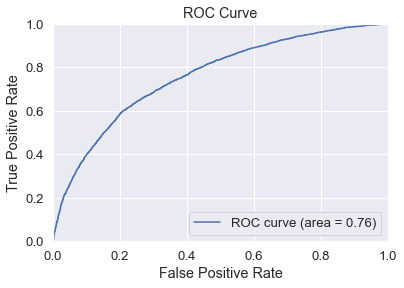

In [275]:
# Predict probabilities and plot the ROC curve
y_pred_prob = logreg_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
logreg_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logreg_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Logistic Regression performed slightly worse than KNN, achieving an accuracy of 0.72, and an AUC of 0.76. The training time was about the same, and the prediction time was considerably faster. The last model to try will be Random Forest. This time Randomized Search will be used instead of Grid Search. This is because Random Forest has a number of different hyperparameters to tune, so the number of combinations is too high for all them to be checked in a reasonable timeframe. Instead the Randomized Search will run for 100 iterations with random combinations of parameters. 

In [175]:
# Define Hyperparameter Grid
random_grid = {'n_estimators': [20, 50, 100, 200, 400, 800],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [5, 10, 20, 30, 40, 50],
               'min_samples_split': [1, 2, 4, 8],
               'min_samples_leaf': [1, 2, 4, 8],
               'bootstrap': [True, False]}

# Create instance of Random Forest Regressor
rf = RandomForestClassifier()

# Create instance of Randomized Search
rf_grid = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=1, 
                          random_state=42, n_jobs = -1)

# Fit model and record run time
start_time = time.time()
rf_grid.fit(X_train, y_train.values.flatten())
end_time = time.time()
rf_grid_time = round(end_time - start_time, 2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.0min finished


In [176]:
# View best parameters and runtime
print('best parameters: {}'.format(rf_grid.best_params_))
print('runtime: {} sec'.format(rf_grid_time))

best parameters: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
runtime: 1326.88 sec


In [177]:
# Get predictions and record prediction time
start_time = time.time()
y_pred = rf_grid.predict(X_test)
end_time = time.time()
rf_grid_pred_time = round((end_time - start_time) * 1000, 2)
print('prediction time: {} ms'.format(rf_grid_pred_time))

prediction time: 421.43 ms


In [178]:
# View classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      7800
           1       0.74      0.66      0.70      4700

    accuracy                           0.78     12500
   macro avg       0.77      0.76      0.76     12500
weighted avg       0.78      0.78      0.78     12500



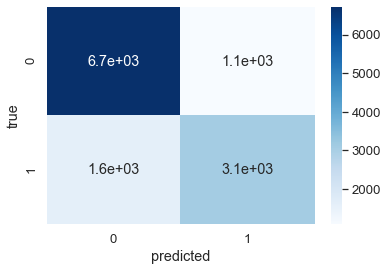

In [185]:
# View confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

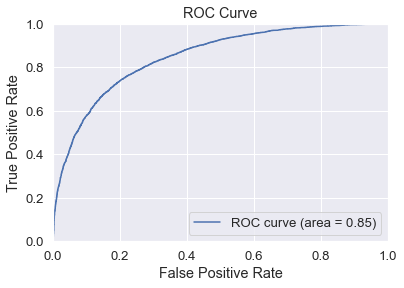

In [180]:
# Predict probabilities and plot the ROC curve
y_pred_prob = rf_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rf_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % rf_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The Random Forest has outperformed each of the other two models, achieving 78% accuracy and an AUC of 0.85. The table below shows the various metrics for all of the models.  The Random Forest takes much longer to train than the others, but the prediction time is not bad. Since it has the best Accuracy and AUC, it is the clear choice of the three models.

In [269]:
model_comparison = pd.DataFrame(
    {'model': ['KNearestNeighbor', 'LogisticRegression', 'RandomForest'],
     'training_time (s)': [knn_grid_time, logreg_grid_time, rf_grid_time],
     'prediction_time (ms)': [knn_grid_pred_time, logreg_grid_pred_time, rf_grid_pred_time],
     'accuracy': [0.76, 0.72, 0.78],
     'roc_auc': [knn_auc, logreg_auc, rf_auc]
    }
)
model_comparison

,model,training_time (s),prediction_time (ms),accuracy,roc_auc
0,KNearestNeighbor,111.19,1859.21,0.76,0.815417
1,LogisticRegression,109.94,5.22,0.72,0.760788
2,RandomForest,1326.88,421.43,0.78,0.849308
